# ModelConductor demo

This short tutorial will cover the basic workflow of conducting One-To-One experiments with ModelConductor. The experiment has two distinct parts, i.e. 

1) The process of writing high-frequency process data to an SQLite database is simulated with a mockup function and

2) The database is concurrently polled and the latest database streamed to a dynamical simulation model, distributed as an Functional Mockup Unit (FMU). The model's output is saved to a csv file

The FMU Model is implemented originally in MapleSim and taken from https://github.com/modelica/fmi-cross-check/tree/master/fmus/2.0/cs/win64/MapleSim/2018/CoupledClutches

The input file to the FMU has been trimmed down to first 1.4 seconds (approx. 1400 samples)

For a more detail description of the various ModelConductor components, read the code or see the original publication in [1]

[1] Aho, P. 2019. An Open Source Digital Twin Framework. Master's Thesis. Tampere University

# Preliminaries

Let us examine what we have, i.e., the FMU model and input data. 

In [1]:
from fmpy import dump

In [2]:
dump('CoupledClutches.fmu')


Model Info

  FMI Version       2.0
  FMI Type          Co-Simulation
  Model Name        CoupledClutches
  Description       Model CoupledClutches
  Platforms         win64
  Continuous States 8
  Event Indicators  25
  Variables         148
  Generation Tool   MapleSim (1357016/1357197/1357197)
  Generation Date   2018-10-25T13:27:07Z

Default Experiment

  Stop Time         1.5
  Step Size         0.01

Variables (input, output)

Name                Causality              Start Value  Unit     Description
inputs              input      0.00000000000000000e+00           RI1
outputs[1]          output     1.00000000000000000e+01  rad/s    J1.w
outputs[2]          output     0.00000000000000000e+00  rad/s    J2.w
outputs[3]          output     0.00000000000000000e+00  rad/s    J3.w
outputs[4]          output     0.00000000000000000e+00  rad/s    J4.w


At each timestep, the model accepts one input and produced an output vector of four elements. The expected step size is 0.01 seconds.

Example input data is contained in a csv file:  

In [3]:
# read in the raw data
import pandas as pd
data = pd.read_csv("CoupledClutches_in_sh.csv")

In [4]:
data.head()

,time,inputs
0,0.000,0
1,0.001,0
2,0.002,0
3,0.003,0
4,0.004,0


In [5]:
len(data)

1421

In [6]:
from matplotlib import pyplot as plt

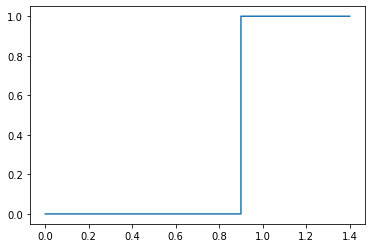

In [7]:
plt.plot(data["time"], data["inputs"])

The input data is essentially a stair function (Clutch engaged / disengaged?)

Let's check the mean time step

In [8]:
data["time"].diff().mean()

0.0009859154761677057

The mean step should be in good accordance with what the model expects

## Receive loop

Using the MQTT experiment class, a broker will be started and one subscriber will be subscribing to the sample messages arriving from the measurements publisher.

## Model loop

The FMU model is wrapped with a corresponding ModelConductor component, thereafter operating on a 'pull' manner. Whenever a previously unseen datapoint is identified as a result of database poll operation, it is relayed to the corresponding ModelHandler component  

In [9]:
from modelconductor.modelhandler import FMUModelHandler

Within ModelConductor, all data that is to be exchanged from one data source / data consumer to another, is asserted to exists in one of two possible formats: 

i) A Measurement object that denotes a timestamped data structure that is received from a physical asset, best understood as a snapshot of the asset’s state at a given time or

ii) a ModelResponse object that similarly denotes a timestamped data structure that is received from a digital asset, a snapshot of the model’s virtual state at a given time 

A variable (a key) may, but is not required to belong to one or more of the following categories:

1) Input keys: The subset of keys in Measurement object corresponding to the keys that are expected as  inputs by the relevant ModelHandler

2) Target keys: The keys that are expected to be output from a ModelHandler instance onto a ModelResponse object

3) Control keys: A subset of keys in Measurement that is not intended to be used as an input to a ModelHandler, but rather as a validation variable against the ModelHandler output

4) Timestamp key: A key denoting the instant when the relevant Measurement or ModelResponce instance was created.


In [10]:
target_keys = ["outputs[1]",
               "outputs[2]",
               "outputs[3]",
               "outputs[4]"]
input_keys = ["inputs"]
control_keys = ["time", "TIMING_client_request_timestamp", 
                "TIMING_model_response_timestamp"]
timestamp_key = "time"

Now the ModelHandler object can be instantiated:

In [11]:
model=FMUModelHandler(
    fmu_path='CoupledClutches.fmu',
    start_time=0,
    stop_time=1.5,
    step_size=0.01,
    target_keys=target_keys,
    input_keys=input_keys,
    control_keys=control_keys,
    timestamp_key=timestamp_key)

## The experiment
The experiment object will use the model inside its subscriber. The broker will start for listening to new measurements from publishers and the subscriber will be listening for new measurements which comes from the broker.

In [12]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

from modelconductor.experiment_mqtt import MqttExperiment

In [13]:
ex = MqttExperiment()
ex.model = model
headers = ["timestamp"]
if ex.model.input_keys:
    headers += ex.model.input_keys
if ex.model.target_keys:
    headers += ex.model.target_keys
if ex.model.control_keys:
    headers += ex.model.control_keys
ex.logger = ex.initiate_logging(headers=headers)

## Run
Run the receiving loop. When it succeeded starting run the client on another process with this command:
```bash
python client_mqtt.py
```

In [14]:
ex.run()

running execute_model_loop!
<class 'modelconductor.modelhandler.FMUModelHandler'>


[2021-02-04 21:48:42,388] :: INFO - Finished processing state new exit callbacks.
[2021-02-04 21:48:42,390] :: INFO - Finished processing state connected enter callbacks.


[OK] [%s]: GUID = %s
[OK] fmi2EnterInitializationMode
{'time': 0.0, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468133.2739742}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0, 'TIMING_client_request_timestamp': 1612468133.2739742, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0, 'TIMING_client_request_timestamp': 1612468133.2739742, 'TIMING_model_response_timestamp': 1612468133.2779646}
{'time': 0.001, 'inputs': 0

{'time': 0.0099999998, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468134.349429}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.338308597170043, 'outputs[2]': 1.0998416454412034, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0099999998, 'TIMING_client_request_timestamp': 1612468134.349429, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 9.338308597170043, 'outputs[2]': 1.0998416454412034, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0099999998, 'TIMING_client_request_timestamp': 1612468134.349429, 'TIMING_model_response_timestamp': 1612468134.3564038}
{'time': 0.0109999999, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.0199999996, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468135.431255}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 9.031847814241853, 'outputs[2]': 2.099385429678063, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0199999996, 'TIMING_client_request_timestamp': 1612468135.431255, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 9.031847814241853, 'outputs[2]': 2.099385429678063, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0199999996, 'TIMING_client_request_timestamp': 1612468135.431255, 'TIMING_model_response_timestamp': 1612468135.4382365}
{'time': 0.0209999997, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.0299999993, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468136.5035417}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.912931729477549, 'outputs[2]': 3.098473481448555, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0299999993, 'TIMING_client_request_timestamp': 1612468136.5035417, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.912931729477549, 'outputs[2]': 3.098473481448555, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0299999993, 'TIMING_client_request_timestamp': 1612468136.5035417, 'TIMING_model_response_timestamp': 1612468136.5115201}
{'time': 0.0309999995, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.0399999991, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468137.5947454}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.895560745283502, 'outputs[2]': 4.096948033175338, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0399999991, 'TIMING_client_request_timestamp': 1612468137.5947454, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.895560745283502, 'outputs[2]': 4.096948033175338, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0399999991, 'TIMING_client_request_timestamp': 1612468137.5947454, 'TIMING_model_response_timestamp': 1612468137.6007297}
{'time': 0.0410000011, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.0500000007, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468138.6776237}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.883855280409843, 'outputs[2]': 5.094651414151982, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0500000007, 'TIMING_client_request_timestamp': 1612468138.6776237, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.883855280409843, 'outputs[2]': 5.094651414151982, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0500000007, 'TIMING_client_request_timestamp': 1612468138.6776237, 'TIMING_model_response_timestamp': 1612468138.6825664}
{'time': 0.050999999, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.0599999987, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468139.771531}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.781456535159583, 'outputs[2]': 6.091426075431008, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0599999987, 'TIMING_client_request_timestamp': 1612468139.771531, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.781456535159583, 'outputs[2]': 6.091426075431008, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0599999987, 'TIMING_client_request_timestamp': 1612468139.771531, 'TIMING_model_response_timestamp': 1612468139.7774746}
{'time': 0.0610000007, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.0700000003, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468140.8671293}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.50097416213343, 'outputs[2]': 7.087114614730006, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0700000003, 'TIMING_client_request_timestamp': 1612468140.8671293, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.50097416213343, 'outputs[2]': 7.087114614730006, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0700000003, 'TIMING_client_request_timestamp': 1612468140.8671293, 'TIMING_model_response_timestamp': 1612468140.8720837}
{'time': 0.0710000023, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.0799999982, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468141.9517252}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.972556028533292, 'outputs[2]': 8.081559801283635, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0799999982, 'TIMING_client_request_timestamp': 1612468141.9517252, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.972556028533292, 'outputs[2]': 8.081559801283635, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0799999982, 'TIMING_client_request_timestamp': 1612468141.951725

{'time': 0.0900000036, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468143.0493388}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.05817102215136, 'outputs[2]': 8.167174794901703, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0900000036, 'TIMING_client_request_timestamp': 1612468143.0493388, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.05817102215136, 'outputs[2]': 8.167174794901703, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0900000036, 'TIMING_client_request_timestamp': 1612468143.0493388, 'TIMING_model_response_timestamp': 1612468143.0572693}
{'time': 0.0909999982, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.1000000015, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468144.1535053}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.988006879461391, 'outputs[2]': 8.097010652211734, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1000000015, 'TIMING_client_request_timestamp': 1612468144.1535053, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.988006879461391, 'outputs[2]': 8.097010652211734, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1000000015, 'TIMING_client_request_timestamp': 1612468144.1535053, 'TIMING_model_response_timestamp': 1612468144.157496}
{'time': 0.1010000035, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.1099999994, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468145.233419}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.768931756088182, 'outputs[2]': 7.877935528838528, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1099999994, 'TIMING_client_request_timestamp': 1612468145.233419, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.768931756088182, 'outputs[2]': 7.877935528838528, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1099999994, 'TIMING_client_request_timestamp': 1612468145.233419, 'TIMING_model_response_timestamp': 1612468145.238363}
{'time': 0.1110000014, 'inputs': 0.0, 'TIMING_client_request_t

{'time': 0.1199999973, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468146.3168542}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.422390252368152, 'outputs[2]': 7.531394025118499, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1199999973, 'TIMING_client_request_timestamp': 1612468146.3168542, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.422390252368152, 'outputs[2]': 7.531394025118499, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1199999973, 'TIMING_client_request_timestamp': 1612468146.3168542, 'TIMING_model_response_timestamp': 1612468146.3207862}
{'time': 0.1209999993, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.1299999952, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468147.3977017}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.982304266372084, 'outputs[2]': 7.09130803912243, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1299999952, 'TIMING_client_request_timestamp': 1612468147.3977017, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.982304266372084, 'outputs[2]': 7.09130803912243, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1299999952, 'TIMING_client_request_timestamp': 1612468147.3977017, 'TIMING_model_response_timestamp': 1612468147.4016478}
{'time': 0.1309999973, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.1400000006, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468148.486592}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.4917524836317355, 'outputs[2]': 6.600756256382082, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1400000006, 'TIMING_client_request_timestamp': 1612468148.486592, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.4917524836317355, 'outputs[2]': 6.600756256382082, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1400000006, 'TIMING_client_request_timestamp': 1612468148.486592, 'TIMING_model_response_timestamp': 1612468148.4985585}
{'time': 0.1410000026, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.150000006, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468149.5853899}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.998753527011476, 'outputs[2]': 6.107757299761823, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.150000006, 'TIMING_client_request_timestamp': 1612468149.5853899, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.998753527011476, 'outputs[2]': 6.107757299761823, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.150000006, 'TIMING_client_request_timestamp': 1612468149.5853899, 'TIMING_model_response_timestamp': 1612468149.5903392}
{'time': 0.1509999931, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.1599999964, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468150.6724238}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.551565570694983, 'outputs[2]': 5.66056934344533, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1599999964, 'TIMING_client_request_timestamp': 1612468150.6724238, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.551565570694983, 'outputs[2]': 5.66056934344533, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1599999964, 'TIMING_client_request_timestamp': 1612468150.6724238, 'TIMING_model_response_timestamp': 1612468150.6793578}
{'time': 0.1609999985, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.1700000018, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468151.7465558}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.193962478760775, 'outputs[2]': 5.302966251511122, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1700000018, 'TIMING_client_request_timestamp': 1612468151.7465558, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.193962478760775, 'outputs[2]': 5.302966251511122, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1700000018, 'TIMING_client_request_timestamp': 1612468151.7465558, 'TIMING_model_response_timestamp': 1612468151.750315}
{'time': 0.1710000038, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.1800000072, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468152.8245}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.9609489518690015, 'outputs[2]': 5.069952724619348, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1800000072, 'TIMING_client_request_timestamp': 1612468152.8245, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.9609489518690015, 'outputs[2]': 5.069952724619348, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1800000072, 'TIMING_client_request_timestamp': 1612468152.8245, 'TIMING_model_response_timestamp': 1612468152.8294868}
{'time': 0.1809999943, 'inputs': 0.0, 'TIMING_client_request_time

{'time': 0.1899999976, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468153.904953}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.875333958352005, 'outputs[2]': 4.984337731102352, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1899999976, 'TIMING_client_request_timestamp': 1612468153.904953, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.875333958352005, 'outputs[2]': 4.984337731102352, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1899999976, 'TIMING_client_request_timestamp': 1612468153.904953, 'TIMING_model_response_timestamp': 1612468153.9159226}
{'time': 0.1909999996, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.200000003, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468154.9992478}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.945498089317083, 'outputs[2]': 5.05450186206743, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.200000003, 'TIMING_client_request_timestamp': 1612468154.9992478, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.945498089317083, 'outputs[2]': 5.05450186206743, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.200000003, 'TIMING_client_request_timestamp': 1612468154.9992478, 'TIMING_model_response_timestamp': 1612468155.0132737}
{'time': 0.201000005, 'inputs': 0.0, 'TIMING_client_request_tim

{'time': 0.2099999934, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468156.0981216}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.164573232999551, 'outputs[2]': 5.273577005749898, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2099999934, 'TIMING_client_request_timestamp': 1612468156.0981216, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.164573232999551, 'outputs[2]': 5.273577005749898, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2099999934, 'TIMING_client_request_timestamp': 1612468156.0981216, 'TIMING_model_response_timestamp': 1612468156.103082}
{'time': 0.2109999955, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.2199999988, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468157.1886668}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.5111147112961305, 'outputs[2]': 5.620118484046477, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2199999988, 'TIMING_client_request_timestamp': 1612468157.1886668, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.5111147112961305, 'outputs[2]': 5.620118484046477, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2199999988, 'TIMING_client_request_timestamp': 1612468157.1886668, 'TIMING_model_response_timestamp': 1612468157.202641}
{'time': 0.2210000008, 'inputs': 0.0, 'TIMING_client_requ

{'time': 0.2300000042, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468158.2891552}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.951200698496694, 'outputs[2]': 6.060204471247041, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2300000042, 'TIMING_client_request_timestamp': 1612468158.2891552, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.951200698496694, 'outputs[2]': 6.060204471247041, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2300000042, 'TIMING_client_request_timestamp': 1612468158.2891552, 'TIMING_model_response_timestamp': 1612468158.2941003}
{'time': 0.2310000062, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.2399999946, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468159.3759544}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.441752482670325, 'outputs[2]': 6.550756255420672, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2399999946, 'TIMING_client_request_timestamp': 1612468159.3759544, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.441752482670325, 'outputs[2]': 6.550756255420672, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2399999946, 'TIMING_client_request_timestamp': 1612468159.3759544, 'TIMING_model_response_timestamp': 1612468159.3847358}
{'time': 0.2409999967, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.25, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468160.4626763}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.934751441452649, 'outputs[2]': 7.043755214202996, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.25, 'TIMING_client_request_timestamp': 1612468160.4626763, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.934751441452649, 'outputs[2]': 7.043755214202996, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.25, 'TIMING_client_request_timestamp': 1612468160.4626763, 'TIMING_model_response_timestamp': 1612468160.4676218}
{'time': 0.2509999871, 'inputs': 0.0, 'TIMING_client_request_timestamp': 161246816

{'time': 0.2599999905, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468161.5444717}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.381939408316852, 'outputs[2]': 7.490943181067199, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2599999905, 'TIMING_client_request_timestamp': 1612468161.5444717, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.381939408316852, 'outputs[2]': 7.490943181067199, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2599999905, 'TIMING_client_request_timestamp': 1612468161.5444717, 'TIMING_model_response_timestamp': 1612468161.5593793}
{'time': 0.2610000074, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.2700000107, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468162.623485}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.73954251688334, 'outputs[2]': 7.848546289633687, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2700000107, 'TIMING_client_request_timestamp': 1612468162.623485, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.73954251688334, 'outputs[2]': 7.848546289633687, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2700000107, 'TIMING_client_request_timestamp': 1612468162.623485, 'TIMING_model_response_timestamp': 1612468162.6384401}
{'time': 0.2709999979, 'inputs': 0.0, 'TIMING_client_request_ti

{'time': 0.2800000012, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468163.7213798}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.972556002840068, 'outputs[2]': 8.081559775590415, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2800000012, 'TIMING_client_request_timestamp': 1612468163.7213798, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.972556002840068, 'outputs[2]': 8.081559775590415, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2800000012, 'TIMING_client_request_timestamp': 1612468163.7213798, 'TIMING_model_response_timestamp': 1612468163.7253695}
{'time': 0.2809999883, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.2899999917, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468164.8031054}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 8.05817099608489, 'outputs[2]': 8.167174768835238, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2899999917, 'TIMING_client_request_timestamp': 1612468164.8031054, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 8.05817099608489, 'outputs[2]': 8.167174768835238, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2899999917, 'TIMING_client_request_timestamp': 1612468164.8031054, 'TIMING_model_response_timestamp': 1612468164.8070931}
{'time': 0.2910000086, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.3000000119, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468165.8789024}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.988006864916542, 'outputs[2]': 8.09701063766689, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3000000119, 'TIMING_client_request_timestamp': 1612468165.8789024, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.988006864916542, 'outputs[2]': 8.09701063766689, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3000000119, 'TIMING_client_request_timestamp': 1612468165.8789024, 'TIMING_model_response_timestamp': 1612468165.8928132}
{'time': 0.300999999, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.3100000024, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468166.968298}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.768931761353742, 'outputs[2]': 7.877935534104089, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3100000024, 'TIMING_client_request_timestamp': 1612468166.968298, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.768931761353742, 'outputs[2]': 7.877935534104089, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3100000024, 'TIMING_client_request_timestamp': 1612468166.968298, 'TIMING_model_response_timestamp': 1612468166.9832585}
{'time': 0.3109999895, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.3199999928, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468168.0547225}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 7.422390250125712, 'outputs[2]': 7.531394022876059, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3199999928, 'TIMING_client_request_timestamp': 1612468168.0547225, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 7.422390250125712, 'outputs[2]': 7.531394022876059, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3199999928, 'TIMING_client_request_timestamp': 1612468168.0547225, 'TIMING_model_response_timestamp': 1612468168.0666866}
{'time': 0.3210000098, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.3300000131, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468169.1317213}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.982304262850121, 'outputs[2]': 7.091308035600468, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3300000131, 'TIMING_client_request_timestamp': 1612468169.1317213, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.982304262850121, 'outputs[2]': 7.091308035600468, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3300000131, 'TIMING_client_request_timestamp': 1612468169.1317213, 'TIMING_model_response_timestamp': 1612468169.135671}
{'time': 0.3310000002, 'inputs': 0.0, 'TIMING_client_reques

{'time': 0.3400000036, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468170.2281518}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 6.491752476553765, 'outputs[2]': 6.600756249304112, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3400000036, 'TIMING_client_request_timestamp': 1612468170.2281518, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 6.491752476553765, 'outputs[2]': 6.600756249304112, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3400000036, 'TIMING_client_request_timestamp': 1612468170.2281518, 'TIMING_model_response_timestamp': 1612468170.2410603}
{'time': 0.3409999907, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.349999994, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468171.3079944}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.998753516306361, 'outputs[2]': 6.107757289056708, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.349999994, 'TIMING_client_request_timestamp': 1612468171.3079944, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.998753516306361, 'outputs[2]': 6.107757289056708, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.349999994, 'TIMING_client_request_timestamp': 1612468171.3079944, 'TIMING_model_response_timestamp': 1612468171.311943}
{'time': 0.351000011, 'inputs': 0.0, 'TIMING_client_request_ti

{'time': 0.3600000143, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468172.3848972}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.55156554938259, 'outputs[2]': 5.660569322132937, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3600000143, 'TIMING_client_request_timestamp': 1612468172.3848972, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.55156554938259, 'outputs[2]': 5.660569322132937, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3600000143, 'TIMING_client_request_timestamp': 1612468172.3848972, 'TIMING_model_response_timestamp': 1612468172.3997993}
{'time': 0.3610000014, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.3700000048, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468173.4804788}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.1939624716569535, 'outputs[2]': 5.3029662444073, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3700000048, 'TIMING_client_request_timestamp': 1612468173.4804788, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.1939624716569535, 'outputs[2]': 5.3029662444073, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3700000048, 'TIMING_client_request_timestamp': 1612468173.4804788, 'TIMING_model_response_timestamp': 1612468173.4924169}
{'time': 0.3709999919, 'inputs': 0.0, 'TIMING_client_request

{'time': 0.3799999952, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468174.5625274}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.960948944320588, 'outputs[2]': 5.069952717070935, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3799999952, 'TIMING_client_request_timestamp': 1612468174.5625274, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.960948944320588, 'outputs[2]': 5.069952717070935, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3799999952, 'TIMING_client_request_timestamp': 1612468174.5625274, 'TIMING_model_response_timestamp': 1612468174.5705035}
{'time': 0.3810000122, 'inputs': 0.0, 'TIMING_client_reque

{'time': 0.3899999857, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468175.658912}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.875333950892521, 'outputs[2]': 4.984337723642867, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3899999857, 'TIMING_client_request_timestamp': 1612468175.658912, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.875333950892521, 'outputs[2]': 4.984337723642867, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3899999857, 'TIMING_client_request_timestamp': 1612468175.658912, 'TIMING_model_response_timestamp': 1612468175.6619043}
{'time': 0.3910000026, 'inputs': 0.0, 'TIMING_client_request_

{'time': 0.400000006, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468176.7415605}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.495498081512554, 'outputs[2]': 4.6045018542629, 'outputs[3]': 0.8999999999999999, 'outputs[4]': 0.0, 'time': 0.400000006, 'TIMING_client_request_timestamp': 1612468176.7415605, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.495498081512554, 'outputs[2]': 4.6045018542629, 'outputs[3]': 0.8999999999999999, 'outputs[4]': 0.0, 'time': 0.400000006, 'TIMING_client_request_timestamp': 1612468176.7415605, 'TIMING_model_response_timestamp': 1612468176.7534811}
{'time': 0.400000006, 'inputs': 0.0

{'time': 0.4090000093, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468177.820096}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.201919903654376, 'outputs[2]': 4.310923676404723, 'outputs[3]': 1.9000000000000006, 'outputs[4]': 0.0, 'time': 0.4090000093, 'TIMING_client_request_timestamp': 1612468177.820096, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.201919903654376, 'outputs[2]': 4.310923676404723, 'outputs[3]': 1.9000000000000006, 'outputs[4]': 0.0, 'time': 0.4090000093, 'TIMING_client_request_timestamp': 1612468177.820096, 'TIMING_model_response_timestamp': 1612468177.8240497}
{'time': 0.4099999964, 'inputs'

{'time': 0.4189999998, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468178.8952596}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.037057845409125, 'outputs[2]': 4.146061618159472, 'outputs[3]': 2.9000000000000012, 'outputs[4]': 0.0, 'time': 0.4189999998, 'TIMING_client_request_timestamp': 1612468178.8952596, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.037057845409125, 'outputs[2]': 4.146061618159472, 'outputs[3]': 2.9000000000000012, 'outputs[4]': 0.0, 'time': 0.4189999998, 'TIMING_client_request_timestamp': 1612468178.8952596, 'TIMING_model_response_timestamp': 1612468178.90719}
{'time': 0.4199999869, 'inputs

{'time': 0.4289999902, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468179.9788828}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.010291684905761, 'outputs[2]': 4.037927142727653, 'outputs[3]': 3.900000000000002, 'outputs[4]': 0.0, 'time': 0.4289999902, 'TIMING_client_request_timestamp': 1612468179.9788828, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.010291684905761, 'outputs[2]': 4.037927142727653, 'outputs[3]': 3.900000000000002, 'outputs[4]': 0.0, 'time': 0.4289999902, 'TIMING_client_request_timestamp': 1612468179.9788828, 'TIMING_model_response_timestamp': 1612468179.9838715}
{'time': 0.4300000072, 'inputs

{'time': 0.4390000105, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468181.067612}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.270097143232038, 'outputs[2]': 4.280819065517455, 'outputs[3]': 4.372543595139539, 'outputs[4]': 0.0, 'time': 0.4390000105, 'TIMING_client_request_timestamp': 1612468181.067612, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.270097143232038, 'outputs[2]': 4.280819065517455, 'outputs[3]': 4.372543595139539, 'outputs[4]': 0.0, 'time': 0.4390000105, 'TIMING_client_request_timestamp': 1612468181.067612, 'TIMING_model_response_timestamp': 1612468181.0715601}
{'time': 0.4399999976, 'inputs': 

{'time': 0.449000001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468182.152171}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.600070207364005, 'outputs[2]': 4.610792129649422, 'outputs[3]': 4.702516659271506, 'outputs[4]': 0.0, 'time': 0.449000001, 'TIMING_client_request_timestamp': 1612468182.152171, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.600070207364005, 'outputs[2]': 4.610792129649422, 'outputs[3]': 4.702516659271506, 'outputs[4]': 0.0, 'time': 0.449000001, 'TIMING_client_request_timestamp': 1612468182.152171, 'TIMING_model_response_timestamp': 1612468182.1561673}
{'time': 0.4499999881, 'inputs': 0.0

{'time': 0.4589999914, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468183.2316213}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.902635951135949, 'outputs[2]': 4.913357873421366, 'outputs[3]': 5.00508240304345, 'outputs[4]': 0.0, 'time': 0.4589999914, 'TIMING_client_request_timestamp': 1612468183.2316213, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.902635951135949, 'outputs[2]': 4.913357873421366, 'outputs[3]': 5.00508240304345, 'outputs[4]': 0.0, 'time': 0.4589999914, 'TIMING_client_request_timestamp': 1612468183.2316213, 'TIMING_model_response_timestamp': 1612468183.2455401}
{'time': 0.4600000083, 'inputs':

{'time': 0.4690000117, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468184.3276236}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.1481771337466045, 'outputs[2]': 5.158899056032022, 'outputs[3]': 5.250623585654106, 'outputs[4]': 0.0, 'time': 0.4690000117, 'TIMING_client_request_timestamp': 1612468184.3276236, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.1481771337466045, 'outputs[2]': 5.158899056032022, 'outputs[3]': 5.250623585654106, 'outputs[4]': 0.0, 'time': 0.4690000117, 'TIMING_client_request_timestamp': 1612468184.3276236, 'TIMING_model_response_timestamp': 1612468184.3345978}
{'time': 0.4699999988, 'inpu

{'time': 0.4790000021, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468185.414496}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.312658475598781, 'outputs[2]': 5.323380397884198, 'outputs[3]': 5.415104927506282, 'outputs[4]': 0.0, 'time': 0.4790000021, 'TIMING_client_request_timestamp': 1612468185.414496, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.312658475598781, 'outputs[2]': 5.323380397884198, 'outputs[3]': 5.415104927506282, 'outputs[4]': 0.0, 'time': 0.4790000021, 'TIMING_client_request_timestamp': 1612468185.414496, 'TIMING_model_response_timestamp': 1612468185.4244664}
{'time': 0.4799999893, 'inputs': 

{'time': 0.4889999926, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468186.5066426}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.379979366629101, 'outputs[2]': 5.390701288914518, 'outputs[3]': 5.482425818536602, 'outputs[4]': 0.0, 'time': 0.4889999926, 'TIMING_client_request_timestamp': 1612468186.5066426, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.379979366629101, 'outputs[2]': 5.390701288914518, 'outputs[3]': 5.482425818536602, 'outputs[4]': 0.0, 'time': 0.4889999926, 'TIMING_client_request_timestamp': 1612468186.5066426, 'TIMING_model_response_timestamp': 1612468186.5125768}
{'time': 0.4900000095, 'inputs

{'time': 0.4990000129, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468187.610623}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.343549998324339, 'outputs[2]': 5.354271920609756, 'outputs[3]': 5.44599645023184, 'outputs[4]': 0.0, 'time': 0.4990000129, 'TIMING_client_request_timestamp': 1612468187.610623, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.343549998324339, 'outputs[2]': 5.354271920609756, 'outputs[3]': 5.44599645023184, 'outputs[4]': 0.0, 'time': 0.4990000129, 'TIMING_client_request_timestamp': 1612468187.610623, 'TIMING_model_response_timestamp': 1612468187.6206074}
{'time': 0.5, 'inputs': 0.0, 'TIMIN

{'time': 0.5090000033, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468188.6890473}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.206936303966668, 'outputs[2]': 5.217658226252085, 'outputs[3]': 5.309382755874169, 'outputs[4]': 0.0, 'time': 0.5090000033, 'TIMING_client_request_timestamp': 1612468188.6890473, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.206936303966668, 'outputs[2]': 5.217658226252085, 'outputs[3]': 5.309382755874169, 'outputs[4]': 0.0, 'time': 0.5090000033, 'TIMING_client_request_timestamp': 1612468188.6890473, 'TIMING_model_response_timestamp': 1612468188.702998}
{'time': 0.5099999905, 'inputs'

{'time': 0.5189999938, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468189.777568}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.983511033379593, 'outputs[2]': 4.994232955665011, 'outputs[3]': 5.0859574852870955, 'outputs[4]': 0.0, 'time': 0.5189999938, 'TIMING_client_request_timestamp': 1612468189.777568, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.983511033379593, 'outputs[2]': 4.994232955665011, 'outputs[3]': 5.0859574852870955, 'outputs[4]': 0.0, 'time': 0.5189999938, 'TIMING_client_request_timestamp': 1612468189.777568, 'TIMING_model_response_timestamp': 1612468189.7825122}
{'time': 0.5199999809, 'inputs'

{'time': 0.5289999843, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468190.8587842}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.69514456371311, 'outputs[2]': 4.705866485998528, 'outputs[3]': 4.797591015620612, 'outputs[4]': 0.0, 'time': 0.5289999843, 'TIMING_client_request_timestamp': 1612468190.8587842, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.69514456371311, 'outputs[2]': 4.705866485998528, 'outputs[3]': 4.797591015620612, 'outputs[4]': 0.0, 'time': 0.5289999843, 'TIMING_client_request_timestamp': 1612468190.8587842, 'TIMING_model_response_timestamp': 1612468190.8726861}
{'time': 0.5299999714, 'inputs':

{'time': 0.5389999747, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468191.9470549}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.370064243047023, 'outputs[2]': 4.380786165332441, 'outputs[3]': 4.472510694954525, 'outputs[4]': 0.0, 'time': 0.5389999747, 'TIMING_client_request_timestamp': 1612468191.9470549, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.370064243047023, 'outputs[2]': 4.380786165332441, 'outputs[3]': 4.472510694954525, 'outputs[4]': 0.0, 'time': 0.5389999747, 'TIMING_client_request_timestamp': 1612468191.9470549, 'TIMING_model_response_timestamp': 1612468191.9520435}
{'time': 0.5400000215, 'inputs

{'time': 0.5490000248, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468193.0342355}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.04009117411962, 'outputs[2]': 4.050813096405038, 'outputs[3]': 4.1425376260271225, 'outputs[4]': 0.0, 'time': 0.5490000248, 'TIMING_client_request_timestamp': 1612468193.0342355, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.04009117411962, 'outputs[2]': 4.050813096405038, 'outputs[3]': 4.1425376260271225, 'outputs[4]': 0.0, 'time': 0.5490000248, 'TIMING_client_request_timestamp': 1612468193.0342355, 'TIMING_model_response_timestamp': 1612468193.0431645}
{'time': 0.5500000119, 'inputs

{'time': 0.5590000153, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468194.111763}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.7375254406976097, 'outputs[2]': 3.7482473629830277, 'outputs[3]': 3.839971892605112, 'outputs[4]': 0.0, 'time': 0.5590000153, 'TIMING_client_request_timestamp': 1612468194.111763, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.7375254406976097, 'outputs[2]': 3.7482473629830277, 'outputs[3]': 3.839971892605112, 'outputs[4]': 0.0, 'time': 0.5590000153, 'TIMING_client_request_timestamp': 1612468194.111763, 'TIMING_model_response_timestamp': 1612468194.1207473}
{'time': 0.5600000024, 'input

{'time': 0.5690000057, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468195.188572}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.4919842565973047, 'outputs[2]': 3.5027061788827227, 'outputs[3]': 3.594430708504807, 'outputs[4]': 0.0, 'time': 0.5690000057, 'TIMING_client_request_timestamp': 1612468195.188572, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.4919842565973047, 'outputs[2]': 3.5027061788827227, 'outputs[3]': 3.594430708504807, 'outputs[4]': 0.0, 'time': 0.5690000057, 'TIMING_client_request_timestamp': 1612468195.188572, 'TIMING_model_response_timestamp': 1612468195.2005477}
{'time': 0.5699999928, 'input

{'time': 0.5789999962, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468196.2707977}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.327502943386119, 'outputs[2]': 3.338224865671537, 'outputs[3]': 3.429949395293621, 'outputs[4]': 0.0, 'time': 0.5789999962, 'TIMING_client_request_timestamp': 1612468196.2707977, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.327502943386119, 'outputs[2]': 3.338224865671537, 'outputs[3]': 3.429949395293621, 'outputs[4]': 0.0, 'time': 0.5789999962, 'TIMING_client_request_timestamp': 1612468196.2707977, 'TIMING_model_response_timestamp': 1612468196.2747493}
{'time': 0.5799999833, 'inputs

{'time': 0.5889999866, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468197.3432796}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.260182022848268, 'outputs[2]': 3.270903945133686, 'outputs[3]': 3.36262847475577, 'outputs[4]': 0.0, 'time': 0.5889999866, 'TIMING_client_request_timestamp': 1612468197.3432796, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.260182022848268, 'outputs[2]': 3.270903945133686, 'outputs[3]': 3.36262847475577, 'outputs[4]': 0.0, 'time': 0.5889999866, 'TIMING_client_request_timestamp': 1612468197.3432796, 'TIMING_model_response_timestamp': 1612468197.3482335}
{'time': 0.5899999738, 'inputs':

{'time': 0.5989999771, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468198.4372237}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2966113909316856, 'outputs[2]': 3.3073333132171037, 'outputs[3]': 3.3990578428391878, 'outputs[4]': 0.0, 'time': 0.5989999771, 'TIMING_client_request_timestamp': 1612468198.4372237, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.2966113909316856, 'outputs[2]': 3.3073333132171037, 'outputs[3]': 3.3990578428391878, 'outputs[4]': 0.0, 'time': 0.5989999771, 'TIMING_client_request_timestamp': 1612468198.4372237, 'TIMING_model_response_timestamp': 1612468198.442166}
{'time': 0.6000000238, 'i

{'time': 0.6090000272, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468199.5295389}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.433225031603297, 'outputs[2]': 3.443946953888715, 'outputs[3]': 3.535671483510799, 'outputs[4]': 0.0, 'time': 0.6090000272, 'TIMING_client_request_timestamp': 1612468199.5295389, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.433225031603297, 'outputs[2]': 3.443946953888715, 'outputs[3]': 3.535671483510799, 'outputs[4]': 0.0, 'time': 0.6090000272, 'TIMING_client_request_timestamp': 1612468199.5295389, 'TIMING_model_response_timestamp': 1612468199.5384698}
{'time': 0.6100000143, 'inputs

{'time': 0.6190000176, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468200.6228566}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.656650310134152, 'outputs[2]': 3.66737223241957, 'outputs[3]': 3.759096762041654, 'outputs[4]': 0.0, 'time': 0.6190000176, 'TIMING_client_request_timestamp': 1612468200.6228566, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.656650310134152, 'outputs[2]': 3.66737223241957, 'outputs[3]': 3.759096762041654, 'outputs[4]': 0.0, 'time': 0.6190000176, 'TIMING_client_request_timestamp': 1612468200.6228566, 'TIMING_model_response_timestamp': 1612468200.627793}
{'time': 0.6200000048, 'inputs': 

{'time': 0.6290000081, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468201.7169094}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.9450167830901335, 'outputs[2]': 3.9557387053755515, 'outputs[3]': 4.047463234997636, 'outputs[4]': 0.0, 'time': 0.6290000081, 'TIMING_client_request_timestamp': 1612468201.7169094, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.9450167830901335, 'outputs[2]': 3.9557387053755515, 'outputs[3]': 4.047463234997636, 'outputs[4]': 0.0, 'time': 0.6290000081, 'TIMING_client_request_timestamp': 1612468201.7169094, 'TIMING_model_response_timestamp': 1612468201.7218473}
{'time': 0.6299999952, 'in

{'time': 0.6389999986, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468202.810229}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.270097119165011, 'outputs[2]': 4.280819041450429, 'outputs[3]': 4.372543571072514, 'outputs[4]': 0.0, 'time': 0.6389999986, 'TIMING_client_request_timestamp': 1612468202.810229, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.270097119165011, 'outputs[2]': 4.280819041450429, 'outputs[3]': 4.372543571072514, 'outputs[4]': 0.0, 'time': 0.6389999986, 'TIMING_client_request_timestamp': 1612468202.810229, 'TIMING_model_response_timestamp': 1612468202.8151665}
{'time': 0.6399999857, 'inputs': 

{'time': 0.648999989, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468203.8930159}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.600070180345008, 'outputs[2]': 4.610792102630426, 'outputs[3]': 4.702516632252511, 'outputs[4]': 0.0, 'time': 0.648999989, 'TIMING_client_request_timestamp': 1612468203.8930159, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.600070180345008, 'outputs[2]': 4.610792102630426, 'outputs[3]': 4.702516632252511, 'outputs[4]': 0.0, 'time': 0.648999989, 'TIMING_client_request_timestamp': 1612468203.8930159, 'TIMING_model_response_timestamp': 1612468203.9059691}
{'time': 0.6499999762, 'inputs': 

{'time': 0.6589999795, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468205.003222}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.902635936503507, 'outputs[2]': 4.913357858788925, 'outputs[3]': 5.00508238841101, 'outputs[4]': 0.0, 'time': 0.6589999795, 'TIMING_client_request_timestamp': 1612468205.003222, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.902635936503507, 'outputs[2]': 4.913357858788925, 'outputs[3]': 5.00508238841101, 'outputs[4]': 0.0, 'time': 0.6589999795, 'TIMING_client_request_timestamp': 1612468205.003222, 'TIMING_model_response_timestamp': 1612468205.0071802}
{'time': 0.6600000262, 'inputs': 0.

{'time': 0.6690000296, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468206.0917478}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.148177120438001, 'outputs[2]': 5.158899042723419, 'outputs[3]': 5.250623572345504, 'outputs[4]': 0.0, 'time': 0.6690000296, 'TIMING_client_request_timestamp': 1612468206.0917478, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.148177120438001, 'outputs[2]': 5.158899042723419, 'outputs[3]': 5.250623572345504, 'outputs[4]': 0.0, 'time': 0.6690000296, 'TIMING_client_request_timestamp': 1612468206.0917478, 'TIMING_model_response_timestamp': 1612468206.0957353}
{'time': 0.6700000167, 'inputs

{'time': 0.67900002, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468207.1808953}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.312658439412538, 'outputs[2]': 5.323380361697956, 'outputs[3]': 5.415104891320041, 'outputs[4]': 0.0, 'time': 0.67900002, 'TIMING_client_request_timestamp': 1612468207.1808953, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.312658439412538, 'outputs[2]': 5.323380361697956, 'outputs[3]': 5.415104891320041, 'outputs[4]': 0.0, 'time': 0.67900002, 'TIMING_client_request_timestamp': 1612468207.1808953, 'TIMING_model_response_timestamp': 1612468207.1848469}
{'time': 0.6800000072, 'inputs': 0.0

{'time': 0.6890000105, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468208.2679155}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.379979300886139, 'outputs[2]': 5.390701223171557, 'outputs[3]': 5.482425752793642, 'outputs[4]': 0.0, 'time': 0.6890000105, 'TIMING_client_request_timestamp': 1612468208.2679155, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.379979300886139, 'outputs[2]': 5.390701223171557, 'outputs[3]': 5.482425752793642, 'outputs[4]': 0.0, 'time': 0.6890000105, 'TIMING_client_request_timestamp': 1612468208.2679155, 'TIMING_model_response_timestamp': 1612468208.2828743}
{'time': 0.6899999976, 'inputs

{'time': 0.699000001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468209.3610368}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.343549933394157, 'outputs[2]': 5.354271855679575, 'outputs[3]': 5.44599638530166, 'outputs[4]': 0.0, 'time': 0.699000001, 'TIMING_client_request_timestamp': 1612468209.3610368, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.343549933394157, 'outputs[2]': 5.354271855679575, 'outputs[3]': 5.44599638530166, 'outputs[4]': 0.0, 'time': 0.699000001, 'TIMING_client_request_timestamp': 1612468209.3610368, 'TIMING_model_response_timestamp': 1612468209.3749604}
{'time': 0.6999999881, 'inputs': 0.

{'time': 0.7089999914, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468210.4590728}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.206936294309561, 'outputs[2]': 5.217658216594979, 'outputs[3]': 5.309382746217064, 'outputs[4]': 0.0, 'time': 0.7089999914, 'TIMING_client_request_timestamp': 1612468210.4590728, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.206936294309561, 'outputs[2]': 5.217658216594979, 'outputs[3]': 5.309382746217064, 'outputs[4]': 0.0, 'time': 0.7089999914, 'TIMING_client_request_timestamp': 1612468210.4590728, 'TIMING_model_response_timestamp': 1612468210.4720564}
{'time': 0.7097924948, 'inputs

{'time': 0.7170000076, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468211.5511022}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.995365246302835, 'outputs[2]': 5.006087168588253, 'outputs[3]': 5.0978116982103385, 'outputs[4]': 0.0, 'time': 0.7170000076, 'TIMING_client_request_timestamp': 1612468211.5511022, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.995365246302835, 'outputs[2]': 5.006087168588253, 'outputs[3]': 5.0978116982103385, 'outputs[4]': 0.0, 'time': 0.7170000076, 'TIMING_client_request_timestamp': 1612468211.5511022, 'TIMING_model_response_timestamp': 1612468211.5660214}
{'time': 0.7179999948, 'inpu

{'time': 0.7269999981, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468212.6445203}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.71789565823151, 'outputs[2]': 4.728617580516928, 'outputs[3]': 4.820342110139014, 'outputs[4]': 0.0, 'time': 0.7269999981, 'TIMING_client_request_timestamp': 1612468212.6445203, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.71789565823151, 'outputs[2]': 4.728617580516928, 'outputs[3]': 4.820342110139014, 'outputs[4]': 0.0, 'time': 0.7269999981, 'TIMING_client_request_timestamp': 1612468212.6445203, 'TIMING_model_response_timestamp': 1612468212.6574388}
{'time': 0.7279999852, 'inputs':

{'time': 0.7369999886, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468213.742368}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.378260497794372, 'outputs[2]': 4.4181175558572, 'outputs[3]': 4.509842085479286, 'outputs[4]': 0.0, 'time': 0.7369999886, 'TIMING_client_request_timestamp': 1612468213.742368, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.378260497794372, 'outputs[2]': 4.4181175558572, 'outputs[3]': 4.509842085479286, 'outputs[4]': 0.0, 'time': 0.7369999886, 'TIMING_client_request_timestamp': 1612468213.742368, 'TIMING_model_response_timestamp': 1612468213.7463589}
{'time': 0.7379999757, 'inputs': 0.0,

{'time': 0.746999979, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468214.8293612}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.9703327819957477, 'outputs[2]': 4.1246673729596495, 'outputs[3]': 4.216391902581735, 'outputs[4]': 0.0, 'time': 0.746999979, 'TIMING_client_request_timestamp': 1612468214.8293612, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.9703327819957477, 'outputs[2]': 4.1246673729596495, 'outputs[3]': 4.216391902581735, 'outputs[4]': 0.0, 'time': 0.746999979, 'TIMING_client_request_timestamp': 1612468214.8293612, 'TIMING_model_response_timestamp': 1612468214.834142}
{'time': 0.7480000257, 'inputs

{'time': 0.7570000291, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468215.9146652}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.6153724488033117, 'outputs[2]': 3.836327414991128, 'outputs[3]': 3.9280519446132134, 'outputs[4]': 0.0, 'time': 0.7570000291, 'TIMING_client_request_timestamp': 1612468215.9146652, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.6153724488033117, 'outputs[2]': 3.836327414991128, 'outputs[3]': 3.9280519446132134, 'outputs[4]': 0.0, 'time': 0.7570000291, 'TIMING_client_request_timestamp': 1612468215.9146652, 'TIMING_model_response_timestamp': 1612468215.9314284}
{'time': 0.7580000162, 'in

{'time': 0.7670000196, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468217.0076656}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.4044839085956706, 'outputs[2]': 3.553143214190022, 'outputs[3]': 3.6448677438121075, 'outputs[4]': 0.0, 'time': 0.7670000196, 'TIMING_client_request_timestamp': 1612468217.0076656, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.4044839085956706, 'outputs[2]': 3.553143214190022, 'outputs[3]': 3.6448677438121075, 'outputs[4]': 0.0, 'time': 0.7670000196, 'TIMING_client_request_timestamp': 1612468217.0076656, 'TIMING_model_response_timestamp': 1612468217.0195665}
{'time': 0.7680000067, 'in

{'time': 0.77700001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468218.1037679}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3387364909629076, 'outputs[2]': 3.3126218037726787, 'outputs[3]': 3.404346333394764, 'outputs[4]': 0.0, 'time': 0.77700001, 'TIMING_client_request_timestamp': 1612468218.1037679, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.3387364909629076, 'outputs[2]': 3.3126218037726787, 'outputs[3]': 3.404346333394764, 'outputs[4]': 0.0, 'time': 0.77700001, 'TIMING_client_request_timestamp': 1612468218.1037679, 'TIMING_model_response_timestamp': 1612468218.1077197}
{'time': 0.7779999971, 'inputs':

{'time': 0.7870000005, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468219.1913397}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.251136469248241, 'outputs[2]': 3.225021782058012, 'outputs[3]': 3.3167463116800975, 'outputs[4]': 0.0, 'time': 0.7870000005, 'TIMING_client_request_timestamp': 1612468219.1913397, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.251136469248241, 'outputs[2]': 3.225021782058012, 'outputs[3]': 3.3167463116800975, 'outputs[4]': 0.0, 'time': 0.7870000005, 'TIMING_client_request_timestamp': 1612468219.1913397, 'TIMING_model_response_timestamp': 1612468219.2042615}
{'time': 0.7879999876, 'inpu

{'time': 0.7950000167, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468220.272755}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.257731452132255, 'outputs[2]': 3.231616764942026, 'outputs[3]': 3.3233412945641114, 'outputs[4]': 0.0, 'time': 0.7950000167, 'TIMING_client_request_timestamp': 1612468220.272755, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.257731452132255, 'outputs[2]': 3.231616764942026, 'outputs[3]': 3.3233412945641114, 'outputs[4]': 0.0, 'time': 0.7950000167, 'TIMING_client_request_timestamp': 1612468220.272755, 'TIMING_model_response_timestamp': 1612468220.2767131}
{'time': 0.7960000038, 'inputs'

{'time': 0.8050000072, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468221.3573942}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3553463462512423, 'outputs[2]': 3.3292316590610134, 'outputs[3]': 3.420956188683099, 'outputs[4]': 0.0, 'time': 0.8050000072, 'TIMING_client_request_timestamp': 1612468221.3573942, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.3553463462512423, 'outputs[2]': 3.3292316590610134, 'outputs[3]': 3.420956188683099, 'outputs[4]': 0.0, 'time': 0.8050000072, 'TIMING_client_request_timestamp': 1612468221.3573942, 'TIMING_model_response_timestamp': 1612468221.3673768}
{'time': 0.8059999943, 'in

{'time': 0.8149999976, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468222.4573207}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.546235404242982, 'outputs[2]': 3.520120717052753, 'outputs[3]': 3.6118452466748385, 'outputs[4]': 0.0, 'time': 0.8149999976, 'TIMING_client_request_timestamp': 1612468222.4573207, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.546235404242982, 'outputs[2]': 3.520120717052753, 'outputs[3]': 3.6118452466748385, 'outputs[4]': 0.0, 'time': 0.8149999976, 'TIMING_client_request_timestamp': 1612468222.4573207, 'TIMING_model_response_timestamp': 1612468222.4613101}
{'time': 0.8159999847, 'inpu

{'time': 0.8249999881, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468223.5453238}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 3.833489321826297, 'outputs[2]': 3.7747101907520904, 'outputs[3]': 3.866434720374176, 'outputs[4]': 0.0, 'time': 0.8249999881, 'TIMING_client_request_timestamp': 1612468223.5453238, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 3.833489321826297, 'outputs[2]': 3.7747101907520904, 'outputs[3]': 3.866434720374176, 'outputs[4]': 0.0, 'time': 0.8249999881, 'TIMING_client_request_timestamp': 1612468223.5453238, 'TIMING_model_response_timestamp': 1612468223.5493054}
{'time': 0.8259999752, 'inpu

{'time': 0.8311672211, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468224.6200397}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.277007378338264, 'outputs[2]': 4.0219928283903155, 'outputs[3]': 4.113717358012401, 'outputs[4]': 0.0, 'time': 0.8311672211, 'TIMING_client_request_timestamp': 1612468224.6200397, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.277007378338264, 'outputs[2]': 4.0219928283903155, 'outputs[3]': 4.113717358012401, 'outputs[4]': 0.0, 'time': 0.8311672211, 'TIMING_client_request_timestamp': 1612468224.6200397, 'TIMING_model_response_timestamp': 1612468224.629964}
{'time': 0.8320000172, 'input

{'time': 0.8410000205, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468225.7049105}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 4.775775177388362, 'outputs[2]': 4.265680512863575, 'outputs[3]': 4.357405042485661, 'outputs[4]': 0.0, 'time': 0.8410000205, 'TIMING_client_request_timestamp': 1612468225.7049105, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 4.775775177388362, 'outputs[2]': 4.265680512863575, 'outputs[3]': 4.357405042485661, 'outputs[4]': 0.0, 'time': 0.8410000205, 'TIMING_client_request_timestamp': 1612468225.7049105, 'TIMING_model_response_timestamp': 1612468225.7138371}
{'time': 0.8420000076, 'inputs

{'time': 0.851000011, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468226.7942724}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.280495907655481, 'outputs[2]': 4.503871923601595, 'outputs[3]': 4.595596453223681, 'outputs[4]': 0.0, 'time': 0.851000011, 'TIMING_client_request_timestamp': 1612468226.7942724, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.280495907655481, 'outputs[2]': 4.503871923601595, 'outputs[3]': 4.595596453223681, 'outputs[4]': 0.0, 'time': 0.851000011, 'TIMING_client_request_timestamp': 1612468226.7942724, 'TIMING_model_response_timestamp': 1612468226.804254}
{'time': 0.8519999981, 'inputs': 0

{'time': 0.8610000014, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468227.8935635}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.695371086188973, 'outputs[2]': 4.73652030658163, 'outputs[3]': 4.828244836203716, 'outputs[4]': 0.0, 'time': 0.8610000014, 'TIMING_client_request_timestamp': 1612468227.8935635, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.695371086188973, 'outputs[2]': 4.73652030658163, 'outputs[3]': 4.828244836203716, 'outputs[4]': 0.0, 'time': 0.8610000014, 'TIMING_client_request_timestamp': 1612468227.8935635, 'TIMING_model_response_timestamp': 1612468227.897553}
{'time': 0.8619999886, 'inputs': 

{'time': 0.8709999919, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468228.9743772}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.934316913094911, 'outputs[2]': 4.963588923958793, 'outputs[3]': 5.055313453580879, 'outputs[4]': 0.0, 'time': 0.8709999919, 'TIMING_client_request_timestamp': 1612468228.9743772, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.934316913094911, 'outputs[2]': 4.963588923958793, 'outputs[3]': 5.055313453580879, 'outputs[4]': 0.0, 'time': 0.8709999919, 'TIMING_client_request_timestamp': 1612468228.9743772, 'TIMING_model_response_timestamp': 1612468228.9873414}
{'time': 0.871999979, 'inputs'

{'time': 0.8809999824, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468230.059653}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.929561182499215, 'outputs[2]': 5.18504191563667, 'outputs[3]': 5.2767664452587555, 'outputs[4]': 0.0, 'time': 0.8809999824, 'TIMING_client_request_timestamp': 1612468230.059653, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.929561182499215, 'outputs[2]': 5.18504191563667, 'outputs[3]': 5.2767664452587555, 'outputs[4]': 0.0, 'time': 0.8809999824, 'TIMING_client_request_timestamp': 1612468230.059653, 'TIMING_model_response_timestamp': 1612468230.0646396}
{'time': 0.8820000291, 'inputs': 

{'time': 0.8909999728, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1612468231.1412265}
stepping:
[0.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 0.0, 'outputs[1]': 5.638284616105812, 'outputs[2]': 5.400844311602477, 'outputs[3]': 5.492568841224563, 'outputs[4]': 0.0, 'time': 0.8909999728, 'TIMING_client_request_timestamp': 1612468231.1412265, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 0.0, 'outputs[1]': 5.638284616105812, 'outputs[2]': 5.400844311602477, 'outputs[3]': 5.492568841224563, 'outputs[4]': 0.0, 'time': 0.8909999728, 'TIMING_client_request_timestamp': 1612468231.1412265, 'TIMING_model_response_timestamp': 1612468231.1532366}
{'time': 0.8920000196, 'inputs

{'time': 0.8999999762, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468232.240705}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.390836205988861, 'outputs[2]': 5.438953549580322, 'outputs[3]': 5.530678079202408, 'outputs[4]': 0.0, 'time': 0.8999999762, 'TIMING_client_request_timestamp': 1612468232.240705, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.390836205988861, 'outputs[2]': 5.438953549580322, 'outputs[3]': 5.530678079202408, 'outputs[4]': 0.0, 'time': 0.8999999762, 'TIMING_client_request_timestamp': 1612468232.240705, 'TIMING_model_response_timesta

{'time': 0.9079999924, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468233.3241034}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.915028810329266, 'outputs[2]': 4.963146153920728, 'outputs[3]': 5.054870683542814, 'outputs[4]': 0.9999999999999999, 'time': 0.9079999924, 'TIMING_client_request_timestamp': 1612468233.3241034, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.915028810329266, 'outputs[2]': 4.963146153920728, 'outputs[3]': 5.054870683542814, 'outputs[4]': 0.9999999999999999, 'time': 0.9079999924, 'TIMING_client_request_timestamp': 1612468233.3241034, 'TIMING_model_response_timestamp': 1612468233.3281102}


{'time': 0.9179999828, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468234.408281}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.366093080462312, 'outputs[2]': 4.414210424053773, 'outputs[3]': 4.505934953675859, 'outputs[4]': 2.0000000000000004, 'time': 0.9179999828, 'TIMING_client_request_timestamp': 1612468234.408281, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.366093080462312, 'outputs[2]': 4.414210424053773, 'outputs[3]': 4.505934953675859, 'outputs[4]': 2.0000000000000004, 'time': 0.9179999828, 'TIMING_client_request_timestamp': 1612468234.408281, 'TIMING_model_response_timestamp': 1612468234.415261}
{'ti

{'time': 0.9279999733, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468235.4853213}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.7497020432695183, 'outputs[2]': 3.7978193868609798, 'outputs[3]': 3.8895439164830656, 'outputs[4]': 3.0000000000000013, 'time': 0.9279999733, 'TIMING_client_request_timestamp': 1612468235.4853213, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.7497020432695183, 'outputs[2]': 3.7978193868609798, 'outputs[3]': 3.8895439164830656, 'outputs[4]': 3.0000000000000013, 'time': 0.9279999733, 'TIMING_client_request_timestamp': 1612468235.4853213, 'TIMING_model_response_timestamp': 1612468235.499

{'time': 0.9359999895, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468236.3544326}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.2368768999426774, 'outputs[2]': 3.3819171403692456, 'outputs[3]': 3.4736416699913315, 'outputs[4]': 3.574981331879129, 'time': 0.9359999895, 'TIMING_client_request_timestamp': 1612468236.3544326, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.2368768999426774, 'outputs[2]': 3.3819171403692456, 'outputs[3]': 3.4736416699913315, 'outputs[4]': 3.574981331879129, 'time': 0.9359999895, 'TIMING_client_request_timestamp': 1612468236.3544326, 'TIMING_model_response_timestamp': 1612468236.36141

{'time': 0.94599998, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468237.4513311}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.609344439512441, 'outputs[2]': 3.259157686362953, 'outputs[3]': 3.350882215985039, 'outputs[4]': 3.4522218778728364, 'time': 0.94599998, 'TIMING_client_request_timestamp': 1612468237.4513311, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.609344439512441, 'outputs[2]': 3.259157686362953, 'outputs[3]': 3.350882215985039, 'outputs[4]': 3.4522218778728364, 'time': 0.94599998, 'TIMING_client_request_timestamp': 1612468237.4513311, 'TIMING_model_response_timestamp': 1612468237.4592993}
{'time

{'time': 0.9559999704, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468238.5481362}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.0236726707950035, 'outputs[2]': 3.140302177509915, 'outputs[3]': 3.232026707132001, 'outputs[4]': 3.333366369019798, 'time': 0.9559999704, 'TIMING_client_request_timestamp': 1612468238.5481362, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.0236726707950035, 'outputs[2]': 3.140302177509915, 'outputs[3]': 3.232026707132001, 'outputs[4]': 3.333366369019798, 'time': 0.9559999704, 'TIMING_client_request_timestamp': 1612468238.5481362, 'TIMING_model_response_timestamp': 1612468238.5521293}


{'time': 0.9660000205, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468239.6302068}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.5720380900241138, 'outputs[2]': 3.0253693801294634, 'outputs[3]': 3.1170939097515493, 'outputs[4]': 3.2184335716393466, 'time': 0.9660000205, 'TIMING_client_request_timestamp': 1612468239.6302068, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.5720380900241138, 'outputs[2]': 3.0253693801294634, 'outputs[3]': 3.1170939097515493, 'outputs[4]': 3.2184335716393466, 'time': 0.9660000205, 'TIMING_client_request_timestamp': 1612468239.6302068, 'TIMING_model_response_timestamp': 1612468239.638

{'time': 0.976000011, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468240.7129953}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2DoStep: state event at %g, z%d crosses zero -%c-
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3323468880938005, 'outputs[2]': 2.9143774481444646, 'outputs[3]': 3.0061019777665505, 'outputs[4]': 3.107441639654348, 'time': 0.976000011, 'TIMING_client_request_timestamp': 1612468240.7129953, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.3323468880938005, 'outputs[2]': 2.9143774481444646, 'outputs[3]': 3.0061019777665505, 'outputs[4]': 3.107441639654348, 'time': 0.976000011, 'TIMING_client_request_timestamp': 1612468240.71299

{'time': 0.9860000014, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468241.7857387}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3606028791331648, 'outputs[2]': 2.8073439037684347, 'outputs[3]': 2.8990684333905206, 'outputs[4]': 3.000408095278318, 'time': 0.9860000014, 'TIMING_client_request_timestamp': 1612468241.7857387, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.3606028791331648, 'outputs[2]': 2.8073439037684347, 'outputs[3]': 2.8990684333905206, 'outputs[4]': 3.000408095278318, 'time': 0.9860000014, 'TIMING_client_request_timestamp': 1612468241.7857387, 'TIMING_model_response_timestamp': 1612468241.79446

{'time': 0.9959999919, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468242.8823168}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.6854210007459514, 'outputs[2]': 2.704285648825595, 'outputs[3]': 2.796010178447681, 'outputs[4]': 2.8973498403354783, 'time': 0.9959999919, 'TIMING_client_request_timestamp': 1612468242.8823168, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.6854210007459514, 'outputs[2]': 2.704285648825595, 'outputs[3]': 2.796010178447681, 'outputs[4]': 2.8973498403354783, 'time': 0.9959999919, 'TIMING_client_request_timestamp': 1612468242.8823168, 'TIMING_model_response_timestamp': 1612468242.8863063

{'time': 1.0019999743, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468243.9626422}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.2698214921661637, 'outputs[2]': 2.604712034501999, 'outputs[3]': 2.696436564124085, 'outputs[4]': 2.7977762260118824, 'time': 1.0019999743, 'TIMING_client_request_timestamp': 1612468243.9626422, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.2698214921661637, 'outputs[2]': 2.604712034501999, 'outputs[3]': 2.696436564124085, 'outputs[4]': 2.7977762260118824, 'time': 1.0019999743, 'TIMING_client_request_timestamp': 1612468243.9626422, 'TIMING_model_response_timestamp': 1612468243.9686267

{'time': 1.0099999905, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468244.8333774}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.7032386229383114, 'outputs[2]': 2.5846978259825204, 'outputs[3]': 2.6764223556046063, 'outputs[4]': 2.7777620174924036, 'time': 1.0099999905, 'TIMING_client_request_timestamp': 1612468244.8333774, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.7032386229383114, 'outputs[2]': 2.5846978259825204, 'outputs[3]': 2.6764223556046063, 'outputs[4]': 2.7777620174924036, 'time': 1.0099999905, 'TIMING_client_request_timestamp': 1612468244.8333774, 'TIMING_model_response_timestamp': 1612468244.837

{'time': 1.0199999809, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468245.9079697}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.11596477466453, 'outputs[2]': 2.6781501799979193, 'outputs[3]': 2.769874709620005, 'outputs[4]': 2.8712143715078025, 'time': 1.0199999809, 'TIMING_client_request_timestamp': 1612468245.9079697, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.11596477466453, 'outputs[2]': 2.6781501799979193, 'outputs[3]': 2.769874709620005, 'outputs[4]': 2.8712143715078025, 'time': 1.0199999809, 'TIMING_client_request_timestamp': 1612468245.9079697, 'TIMING_model_response_timestamp': 1612468245.9119313}


{'time': 1.0299999714, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468246.9829283}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.7278637991647434, 'outputs[2]': 2.7675744914399414, 'outputs[3]': 2.8592990210620273, 'outputs[4]': 2.9606386829498246, 'time': 1.0299999714, 'TIMING_client_request_timestamp': 1612468246.9829283, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.7278637991647434, 'outputs[2]': 2.7675744914399414, 'outputs[3]': 2.8592990210620273, 'outputs[4]': 2.9606386829498246, 'time': 1.0299999714, 'TIMING_client_request_timestamp': 1612468246.9829283, 'TIMING_model_response_timestamp': 1612468246.986

{'time': 1.0399999619, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468248.0715296}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.452820858712718, 'outputs[2]': 2.8529566392041357, 'outputs[3]': 2.9446811688262216, 'outputs[4]': 3.046020830714019, 'time': 1.0399999619, 'TIMING_client_request_timestamp': 1612468248.0715296, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.452820858712718, 'outputs[2]': 2.8529566392041357, 'outputs[3]': 2.9446811688262216, 'outputs[4]': 3.046020830714019, 'time': 1.0399999619, 'TIMING_client_request_timestamp': 1612468248.0715296, 'TIMING_model_response_timestamp': 1612468248.0844917

{'time': 1.0499999523, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468249.168737}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.194839260695906, 'outputs[2]': 2.934283130797008, 'outputs[3]': 3.026007660419094, 'outputs[4]': 3.1273473223068913, 'time': 1.0499999523, 'TIMING_client_request_timestamp': 1612468249.168737, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.194839260695906, 'outputs[2]': 2.934283130797008, 'outputs[3]': 3.026007660419094, 'outputs[4]': 3.1273473223068913, 'time': 1.0499999523, 'TIMING_client_request_timestamp': 1612468249.168737, 'TIMING_model_response_timestamp': 1612468249.1726837}
{'t

{'time': 1.0599999428, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468250.257192}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.857441215502262, 'outputs[2]': 3.011541133508255, 'outputs[3]': 3.103265663130341, 'outputs[4]': 3.204605325018138, 'time': 1.0599999428, 'TIMING_client_request_timestamp': 1612468250.257192, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.857441215502262, 'outputs[2]': 3.011541133508255, 'outputs[3]': 3.103265663130341, 'outputs[4]': 3.204605325018138, 'time': 1.0599999428, 'TIMING_client_request_timestamp': 1612468250.257192, 'TIMING_model_response_timestamp': 1612468250.2621799}
{'tim

{'time': 1.0700000525, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468251.351187}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.353115487443975, 'outputs[2]': 3.0847184425468632, 'outputs[3]': 3.176442972168949, 'outputs[4]': 3.2777826340567464, 'time': 1.0700000525, 'TIMING_client_request_timestamp': 1612468251.351187, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.353115487443975, 'outputs[2]': 3.0847184425468632, 'outputs[3]': 3.176442972168949, 'outputs[4]': 3.2777826340567464, 'time': 1.0700000525, 'TIMING_client_request_timestamp': 1612468251.351187, 'TIMING_model_response_timestamp': 1612468251.356134}
{'

{'time': 1.0800000429, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468252.4269056}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.611887376355405, 'outputs[2]': 3.153803502364469, 'outputs[3]': 3.245528031986555, 'outputs[4]': 3.3468676938743522, 'time': 1.0800000429, 'TIMING_client_request_timestamp': 1612468252.4269056, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.611887376355405, 'outputs[2]': 3.153803502364469, 'outputs[3]': 3.245528031986555, 'outputs[4]': 3.3468676938743522, 'time': 1.0800000429, 'TIMING_client_request_timestamp': 1612468252.4269056, 'TIMING_model_response_timestamp': 1612468252.4398708}


{'time': 1.0900000334, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468253.5142207}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.588171567514141, 'outputs[2]': 3.218785403629953, 'outputs[3]': 3.310509933252039, 'outputs[4]': 3.411849595139836, 'time': 1.0900000334, 'TIMING_client_request_timestamp': 1612468253.5142207, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.588171567514141, 'outputs[2]': 3.218785403629953, 'outputs[3]': 3.310509933252039, 'outputs[4]': 3.411849595139836, 'time': 1.0900000334, 'TIMING_client_request_timestamp': 1612468253.5142207, 'TIMING_model_response_timestamp': 1612468253.5181785}
{'

{'time': 1.1000000238, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468254.5998986}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.2652376759188355, 'outputs[2]': 3.2796538849327255, 'outputs[3]': 3.3713784145548114, 'outputs[4]': 3.4727180764426087, 'time': 1.1000000238, 'TIMING_client_request_timestamp': 1612468254.5998986, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.2652376759188355, 'outputs[2]': 3.2796538849327255, 'outputs[3]': 3.3713784145548114, 'outputs[4]': 3.4727180764426087, 'time': 1.1000000238, 'TIMING_client_request_timestamp': 1612468254.5998986, 'TIMING_model_response_timestamp': 1612468254.603

{'time': 1.1100000143, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468255.6900241}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.656851188606473, 'outputs[2]': 3.3363993393559284, 'outputs[3]': 3.4281238689780142, 'outputs[4]': 3.5294635308658115, 'time': 1.1100000143, 'TIMING_client_request_timestamp': 1612468255.6900241, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.656851188606473, 'outputs[2]': 3.3363993393559284, 'outputs[3]': 3.4281238689780142, 'outputs[4]': 3.5294635308658115, 'time': 1.1100000143, 'TIMING_client_request_timestamp': 1612468255.6900241, 'TIMING_model_response_timestamp': 1612468255.69397

{'time': 1.1200000048, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468256.7687554}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.80592785198158, 'outputs[2]': 3.3890128012196747, 'outputs[3]': 3.4807373308417606, 'outputs[4]': 3.582076992729558, 'time': 1.1200000048, 'TIMING_client_request_timestamp': 1612468256.7687554, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.80592785198158, 'outputs[2]': 3.3890128012196747, 'outputs[3]': 3.4807373308417606, 'outputs[4]': 3.582076992729558, 'time': 1.1200000048, 'TIMING_client_request_timestamp': 1612468256.7687554, 'TIMING_model_response_timestamp': 1612468256.7816973}


{'time': 1.1299999952, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468257.8553247}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.780336368310412, 'outputs[2]': 3.4374859622451512, 'outputs[3]': 3.529210491867237, 'outputs[4]': 3.6305501537550344, 'time': 1.1299999952, 'TIMING_client_request_timestamp': 1612468257.8553247, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.780336368310412, 'outputs[2]': 3.4374859622451512, 'outputs[3]': 3.529210491867237, 'outputs[4]': 3.6305501537550344, 'time': 1.1299999952, 'TIMING_client_request_timestamp': 1612468257.8553247, 'TIMING_model_response_timestamp': 1612468257.866238}

{'time': 1.1380000114, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468258.7398393}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.0239626223169624, 'outputs[2]': 3.4291604695588074, 'outputs[3]': 3.5208849991808933, 'outputs[4]': 3.6222246610686906, 'time': 1.1380000114, 'TIMING_client_request_timestamp': 1612468258.7398393, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.0239626223169624, 'outputs[2]': 3.4291604695588074, 'outputs[3]': 3.5208849991808933, 'outputs[4]': 3.6222246610686906, 'time': 1.1380000114, 'TIMING_client_request_timestamp': 1612468258.7398393, 'TIMING_model_response_timestamp': 1612468258.746

{'time': 1.1460000277, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468259.8311608}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.1522092370222907, 'outputs[2]': 3.387963337302773, 'outputs[3]': 3.4796878669248588, 'outputs[4]': 3.581027528812656, 'time': 1.1460000277, 'TIMING_client_request_timestamp': 1612468259.8311608, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.1522092370222907, 'outputs[2]': 3.387963337302773, 'outputs[3]': 3.4796878669248588, 'outputs[4]': 3.581027528812656, 'time': 1.1460000277, 'TIMING_client_request_timestamp': 1612468259.8311608, 'TIMING_model_response_timestamp': 1612468259.8480759

{'time': 1.1560000181, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468260.9300036}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3229935241821842, 'outputs[2]': 3.350289143118064, 'outputs[3]': 3.44201367274015, 'outputs[4]': 3.5433533346279473, 'time': 1.1560000181, 'TIMING_client_request_timestamp': 1612468260.9300036, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.3229935241821842, 'outputs[2]': 3.350289143118064, 'outputs[3]': 3.44201367274015, 'outputs[4]': 3.5433533346279473, 'time': 1.1560000181, 'TIMING_client_request_timestamp': 1612468260.9300036, 'TIMING_model_response_timestamp': 1612468260.939935}
{

{'time': 1.1660000086, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468262.0223007}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.6270886676201378, 'outputs[2]': 3.316779732749401, 'outputs[3]': 3.408504262371487, 'outputs[4]': 3.5098439242592843, 'time': 1.1660000086, 'TIMING_client_request_timestamp': 1612468262.0223007, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.6270886676201378, 'outputs[2]': 3.316779732749401, 'outputs[3]': 3.408504262371487, 'outputs[4]': 3.5098439242592843, 'time': 1.1660000086, 'TIMING_client_request_timestamp': 1612468262.0223007, 'TIMING_model_response_timestamp': 1612468262.0282662

{'time': 1.175999999, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468263.1108394}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.14243963214021013, 'outputs[2]': 3.2874404076571904, 'outputs[3]': 3.3791649372792762, 'outputs[4]': 3.4805045991670736, 'time': 1.175999999, 'TIMING_client_request_timestamp': 1612468263.1108394, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.14243963214021013, 'outputs[2]': 3.2874404076571904, 'outputs[3]': 3.3791649372792762, 'outputs[4]': 3.4805045991670736, 'time': 1.175999999, 'TIMING_client_request_timestamp': 1612468263.1108394, 'TIMING_model_response_timestamp': 1612468263.1198

{'time': 1.1859999895, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468264.199682}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': -0.07491134982670097, 'outputs[2]': 3.2622757909179714, 'outputs[3]': 3.3540003205400573, 'outputs[4]': 3.4553399824278546, 'time': 1.1859999895, 'TIMING_client_request_timestamp': 1612468264.199682, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': -0.07491134982670097, 'outputs[2]': 3.2622757909179714, 'outputs[3]': 3.3540003205400573, 'outputs[4]': 3.4553399824278546, 'time': 1.1859999895, 'TIMING_client_request_timestamp': 1612468264.199682, 'TIMING_model_response_timestamp': 1612468264.20

{'time': 1.19599998, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468265.2825415}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.003690153408895013, 'outputs[2]': 3.2412898662808054, 'outputs[3]': 3.3330143959028913, 'outputs[4]': 3.4343540577906886, 'time': 1.19599998, 'TIMING_client_request_timestamp': 1612468265.2825415, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.003690153408895013, 'outputs[2]': 3.2412898662808054, 'outputs[3]': 3.3330143959028913, 'outputs[4]': 3.4343540577906886, 'time': 1.19599998, 'TIMING_client_request_timestamp': 1612468265.2825415, 'TIMING_model_response_timestamp': 1612468265.28852

{'time': 1.2059999704, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468266.364744}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.3767021896500826, 'outputs[2]': 3.224485937700761, 'outputs[3]': 3.316210467322847, 'outputs[4]': 3.4175501292106443, 'time': 1.2059999704, 'TIMING_client_request_timestamp': 1612468266.364744, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.3767021896500826, 'outputs[2]': 3.224485937700761, 'outputs[3]': 3.316210467322847, 'outputs[4]': 3.4175501292106443, 'time': 1.2059999704, 'TIMING_client_request_timestamp': 1612468266.364744, 'TIMING_model_response_timestamp': 1612468266.3697295}
{

{'time': 1.2159999609, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468267.453377}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.012538763242507, 'outputs[2]': 3.2118666636895568, 'outputs[3]': 3.3035911933116426, 'outputs[4]': 3.40493085519944, 'time': 1.2159999609, 'TIMING_client_request_timestamp': 1612468267.453377, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.012538763242507, 'outputs[2]': 3.2118666636895568, 'outputs[3]': 3.3035911933116426, 'outputs[4]': 3.40493085519944, 'time': 1.2159999609, 'TIMING_client_request_timestamp': 1612468267.453377, 'TIMING_model_response_timestamp': 1612468267.4593606}
{'t

{'time': 1.2259999514, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468268.533717}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.8526595756833952, 'outputs[2]': 3.2034340369849783, 'outputs[3]': 3.295158566607064, 'outputs[4]': 3.3964982284948615, 'time': 1.2259999514, 'TIMING_client_request_timestamp': 1612468268.533717, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.8526595756833952, 'outputs[2]': 3.2034340369849783, 'outputs[3]': 3.295158566607064, 'outputs[4]': 3.3964982284948615, 'time': 1.2259999514, 'TIMING_client_request_timestamp': 1612468268.533717, 'TIMING_model_response_timestamp': 1612468268.5466852}

{'time': 1.2359999418, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468269.633663}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.8172999358519926, 'outputs[2]': 3.1991893842051597, 'outputs[3]': 3.2909139138272456, 'outputs[4]': 3.392253575715043, 'time': 1.2359999418, 'TIMING_client_request_timestamp': 1612468269.633663, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.8172999358519926, 'outputs[2]': 3.1991893842051597, 'outputs[3]': 3.2909139138272456, 'outputs[4]': 3.392253575715043, 'time': 1.2359999418, 'TIMING_client_request_timestamp': 1612468269.633663, 'TIMING_model_response_timestamp': 1612468269.6376152}

{'time': 1.243999958, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468270.5066283}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.616625961952289, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.243999958, 'TIMING_client_request_timestamp': 1612468270.5066283, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.616625961952289, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.243999958, 'TIMING_client_request_timestamp': 1612468270.5066283, 'TIMING_model_response_timestamp': 1612468270.5115724}

{'time': 1.2519999743, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468271.599728}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.58145130857838, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2519999743, 'TIMING_client_request_timestamp': 1612468271.599728, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.58145130857838, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2519999743, 'TIMING_client_request_timestamp': 1612468271.599728, 'TIMING_model_response_timestamp': 1612468271.6036808}
{

{'time': 1.2619999647, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468272.6733124}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.44655078128239, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2619999647, 'TIMING_client_request_timestamp': 1612468272.6733124, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.44655078128239, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2619999647, 'TIMING_client_request_timestamp': 1612468272.6733124, 'TIMING_model_response_timestamp': 1612468272.6852715

{'time': 1.2719999552, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468273.7660613}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.1168264195638935, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2719999552, 'TIMING_client_request_timestamp': 1612468273.7660613, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.1168264195638935, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2719999552, 'TIMING_client_request_timestamp': 1612468273.7660613, 'TIMING_model_response_timestamp': 1612468273.777

{'time': 1.2819999456, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468274.863623}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.526667467562788, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2819999456, 'TIMING_client_request_timestamp': 1612468274.863623, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.526667467562788, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2819999456, 'TIMING_client_request_timestamp': 1612468274.863623, 'TIMING_model_response_timestamp': 1612468274.8755915}

{'time': 1.2920000553, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468275.9617505}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.635955903778474, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2920000553, 'TIMING_client_request_timestamp': 1612468275.9617505, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.635955903778474, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.2920000553, 'TIMING_client_request_timestamp': 1612468275.9617505, 'TIMING_model_response_timestamp': 1612468275.96773

{'time': 1.3020000458, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468277.0461555}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 6.433993096258866, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3020000458, 'TIMING_client_request_timestamp': 1612468277.0461555, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 6.433993096258866, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3020000458, 'TIMING_client_request_timestamp': 1612468277.0461555, 'TIMING_model_response_timestamp': 1612468277.05214

{'time': 1.3120000362, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468278.146098}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.94054926930804, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3120000362, 'TIMING_client_request_timestamp': 1612468278.146098, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.94054926930804, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3120000362, 'TIMING_client_request_timestamp': 1612468278.146098, 'TIMING_model_response_timestamp': 1612468278.1520715}
{

{'time': 1.3220000267, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468279.236803}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 5.203925566531014, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3220000267, 'TIMING_client_request_timestamp': 1612468279.236803, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 5.203925566531014, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3220000267, 'TIMING_client_request_timestamp': 1612468279.236803, 'TIMING_model_response_timestamp': 1612468279.2517707}

{'time': 1.3320000172, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468280.333884}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 4.296228348705576, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3320000172, 'TIMING_client_request_timestamp': 1612468280.333884, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 4.296228348705576, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3320000172, 'TIMING_client_request_timestamp': 1612468280.333884, 'TIMING_model_response_timestamp': 1612468280.3388712}

{'time': 1.3420000076, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468281.4246438}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 3.306309152202719, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3420000076, 'TIMING_client_request_timestamp': 1612468281.4246438, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 3.306309152202719, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3420000076, 'TIMING_client_request_timestamp': 1612468281.4246438, 'TIMING_model_response_timestamp': 1612468281.42959

{'time': 1.3519999981, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468282.5081053}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 2.3310681549593144, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3519999981, 'TIMING_client_request_timestamp': 1612468282.5081053, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 2.3310681549593144, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3519999981, 'TIMING_client_request_timestamp': 1612468282.5081053, 'TIMING_model_response_timestamp': 1612468282.525

{'time': 1.3619999886, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468283.6020918}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 1.4659686417642872, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3619999886, 'TIMING_client_request_timestamp': 1612468283.6020918, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 1.4659686417642872, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3619999886, 'TIMING_client_request_timestamp': 1612468283.6020918, 'TIMING_model_response_timestamp': 1612468283.607

{'time': 1.371999979, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468284.6834104}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.7956930031390507, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.371999979, 'TIMING_client_request_timestamp': 1612468284.6834104, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.7956930031390507, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.371999979, 'TIMING_client_request_timestamp': 1612468284.6834104, 'TIMING_model_response_timestamp': 1612468284.688354

{'time': 1.3819999695, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468285.777104}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.38585195448546306, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3819999695, 'TIMING_client_request_timestamp': 1612468285.777104, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.38585195448546306, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3819999695, 'TIMING_client_request_timestamp': 1612468285.777104, 'TIMING_model_response_timestamp': 1612468285.7810

{'time': 1.3919999599, 'inputs': 1.0, 'TIMING_client_request_timestamp': 1612468286.8479419}
stepping:
[1.0]
[OK] fmi2SetReal: nvr = %d
[OK] fmi2SetReal: #r%d# = %.16g
[OK] fmi2DoStep: currentCommunicationPoint = %g, communicationStepSize = %g, newStep = fmi2%s
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
[OK] fmi2GetReal: #r%u# = %.16g
Got response from model {'inputs': 1.0, 'outputs[1]': 0.27656389151517957, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3919999599, 'TIMING_client_request_timestamp': 1612468286.8479419, 'TIMING_model_response_timestamp': 0}
result: 
{'inputs': 1.0, 'outputs[1]': 0.27656389151517957, 'outputs[2]': 3.1986908709847395, 'outputs[3]': 3.2904154006068254, 'outputs[4]': 3.3917550624946227, 'time': 1.3919999599, 'TIMING_client_request_timestamp': 1612468286.8479419, 'TIMING_model_response_timestamp': 1612468286.8

## Results
A crucial point of interest in the timeline of a ModelConductor Experiment is the instant when the ModelResponse object is returned, concluding a single iteration of the model loop depicted in Figure 17. At this point, the contents of ModelResponse of the time step are written to an external file as comma separated values, ordered in the following manner:
timestamp ,input\_keys ,target\_keys ,control\_keys

Let's examine the results of the experiment

In [15]:
print(ex.log_path)
pd.options.display.float_format = '{:.5f}'.format

results = pd.read_csv(ex.log_path)
results.head()

experiment_2021-02-04_21-48-40.log


,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time,TIMING_client_request_timestamp,TIMING_model_response_timestamp
0,2021-02-04 21:48:53.280956,0.00000,9.90000,0.10000,0.00000,0.00000,0.00000,1612468133.27397,1612468133.27796
1,2021-02-04 21:48:53.393221,0.00000,9.83091,0.19999,0.00000,0.00000,0.00100,1612468133.37726,1612468133.38824
2,2021-02-04 21:48:53.493241,0.00000,9.76479,0.29998,0.00000,0.00000,0.00200,1612468133.48728,1612468133.49222
3,2021-02-04 21:48:53.607719,0.00000,9.70161,0.39997,0.00000,0.00000,0.00300,1612468133.59293,1612468133.60573
4,2021-02-04 21:48:53.716975,0.00000,9.64134,0.49996,0.00000,0.00000,0.00400,1612468133.70307,1612468133.71399


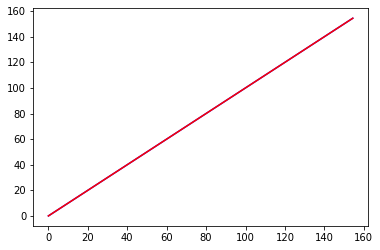

In [16]:
results['TIMING_client_request_timestamp_zerobased'] = results["TIMING_client_request_timestamp"] - \
                                                        results["TIMING_client_request_timestamp"].iloc[0]
results['TIMING_model_response_timestamp_zerobased'] = results["TIMING_model_response_timestamp"] - \
                                                        results["TIMING_client_request_timestamp"].iloc[0]
local_results = results[:]
plt.plot(local_results["TIMING_client_request_timestamp_zerobased"], local_results["TIMING_client_request_timestamp_zerobased"], 'b',
        local_results["TIMING_client_request_timestamp_zerobased"], local_results["TIMING_model_response_timestamp_zerobased"], 'r')
plt.show()

1421
0.009900877796202625
0.004248656203900876
0.017914533615112305
0.002894163131713867


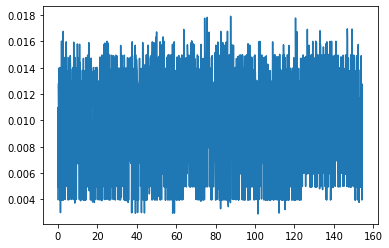

[2021-02-05 03:53:44,587] :: WARNING - Disconnected from broker


In [26]:
delta_t = results["TIMING_model_response_timestamp"].sub(results["TIMING_client_request_timestamp"])
print(len(delta_t))
print(delta_t.mean())
print(delta_t.std())
print(delta_t.max())
print(delta_t.min())

plt.plot(results["TIMING_client_request_timestamp_zerobased"], delta_t)
plt.show()

In [18]:
len(results)

1421

Plot the simulation outputs

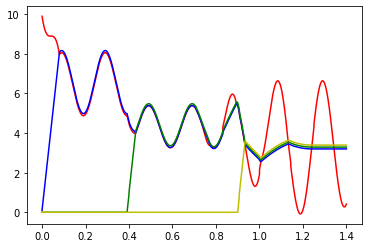

In [19]:
plt.plot(results["time"], results["outputs[1]"], 'r',
         results["time"], results["outputs[2]"], 'b',
         results["time"], results["outputs[3]"],  'g',
         results["time"], results["outputs[4]"], 'y')
plt.show()

Plot the inputs

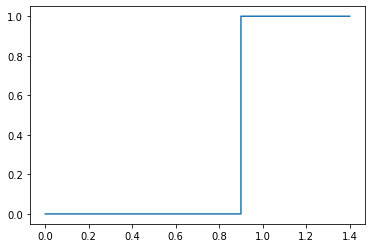

In [20]:
plt.plot(results["time"], results["inputs"])

A log entry is written each time a ModelResponse object is received from the FMUModelHandler instance. Having a priori knowledge about how much the simulated time advances between two consecutive ModelResponses (in this case, approximately 0.001 seconds) allows to define the following:

t = simulated time elapsed since beginning of the experiment

tau = wall-clock time elapsed since beginning of the experiment

t/tau = real-time performance coefficient

Let's plot the t/tau metric for the current demo (slight preprocessing involved)

In [21]:
results['timestamp'] = pd.to_datetime(results['timestamp'])

In [22]:
results['elapsed_wallclock'] = pd.to_timedelta(results['timestamp']).dt.total_seconds() - \
pd.to_timedelta(results['timestamp']).dt.total_seconds().iloc[0]

c:\users\sajad20h\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [23]:
results.head()

,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time,TIMING_client_request_timestamp,TIMING_model_response_timestamp,TIMING_client_request_timestamp_zerobased,TIMING_model_response_timestamp_zerobased,elapsed_wallclock
0,2021-02-04 21:48:53.280956,0.00000,9.90000,0.10000,0.00000,0.00000,0.00000,1612468133.27397,1612468133.27796,0.00000,0.00399,0.00000
1,2021-02-04 21:48:53.393221,0.00000,9.83091,0.19999,0.00000,0.00000,0.00100,1612468133.37726,1612468133.38824,0.10328,0.11426,0.11227
2,2021-02-04 21:48:53.493241,0.00000,9.76479,0.29998,0.00000,0.00000,0.00200,1612468133.48728,1612468133.49222,0.21331,0.21824,0.21229
3,2021-02-04 21:48:53.607719,0.00000,9.70161,0.39997,0.00000,0.00000,0.00300,1612468133.59293,1612468133.60573,0.31896,0.33175,0.32676
4,2021-02-04 21:48:53.716975,0.00000,9.64134,0.49996,0.00000,0.00000,0.00400,1612468133.70307,1612468133.71399,0.42909,0.44001,0.43602


In [24]:
t_per_tau = results["time"].divide(results["elapsed_wallclock"])

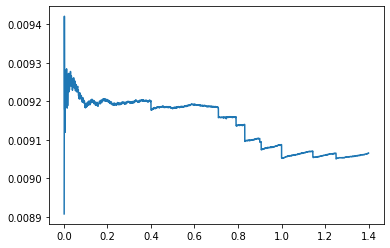

In [25]:
plt.plot(results["time"], t_per_tau)
plt.show()

## Discussion

Obviously the performance is very poor with the database operations as the bottleneck. Things could be improved substantially by introducing another means of accessing the input data, e.g., a TCP socket or similar.

See the original publication in [1] for further discussion